# Data Augmentation in NumPy

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.ndimage import rotate

sns.set(color_codes=True)

In [2]:
img = np.array(plt.imread('/home/igor/lenna.png'))

Text(0.5, 1.0, 'RGB Distribution')

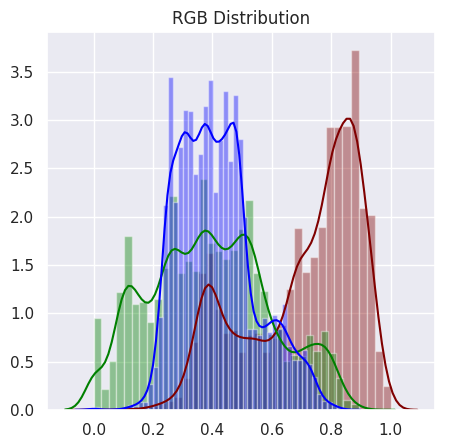

In [3]:
plt.figure(figsize=(5, 5), dpi=100)
sns.distplot(img[:, :, 0].flatten(), color='maroon')
sns.distplot(img[:, :, 1].flatten(), color='green')
sns.distplot(img[:, :, 2].flatten(), color='blue').set_title('RGB Distribution')

In [4]:
def show_img(img, ax):
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(img)

    
def plot_grid(imgs, nrows, ncols, figsize=(10, 10)):
    assert len(imgs) == nrows*ncols, f"Number of images should be {nrows}x{ncols}"
    _, axs = plt.subplots(nrows, ncols, figsize=figsize)
    axs = axs.flatten()
    for img, ax in zip(imgs, axs):
        show_img(img, ax)

### Translations

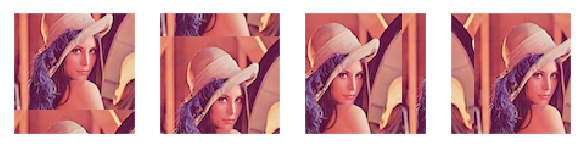

In [5]:
def translate(img, shift=10, direction='right', roll=True):
    assert direction in ['right', 'left', 'down', 'up'], 'Directions should be top|up|left|right'
    img = img.copy()
    if direction == 'right':
        right_slice = img[:, -shift:].copy()
        img[:, shift:] = img[:, :-shift]
        if roll:
            img[:,:shift] = np.fliplr(right_slice)
    if direction == 'left':
        left_slice = img[:, :shift].copy()
        img[:, :-shift] = img[:, shift:]
        if roll:
            img[:, -shift:] = left_slice
    if direction == 'down':
        down_slice = img[-shift:, :].copy()
        img[shift:, :] = img[:-shift,:]
        if roll:
            img[:shift, :] = down_slice
    if direction == 'up':
        upper_slice = img[:shift, :].copy()
        img[:-shift, :] = img[shift:, :]
        if roll:
            img[-shift:,:] = upper_slice
    return img


plot_grid([translate(img, direction='up', shift=20),
           translate(img, direction='down', shift=20), 
           translate(img, direction='left', shift=20),
           translate(img, direction='right', shift=20)],
           1, 4, figsize=(10, 5))

In [6]:
def random_crop(img, crop_size=(10, 10)):
    assert crop_size[0] <= img.shape[0] and crop_size[1] <= img.shape[1], "Crop size should be less than image size"
    img = img.copy()
    w, h = img.shape[:2]
    x, y = np.random.randint(h-crop_size[0]), np.random.randint(w-crop_size[1])
    img = img[y:y+crop_size[0], x:x+crop_size[1]]
    return img

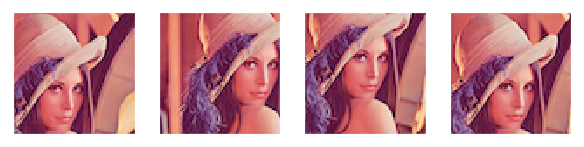

In [7]:
plot_grid([random_crop(img, crop_size=(70, 70)),
           random_crop(img, crop_size=(70, 70)),
           random_crop(img, crop_size=(70, 70)),
           random_crop(img, crop_size=(70, 70))],
           1, 4, figsize=(10, 5))

### Rotations

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


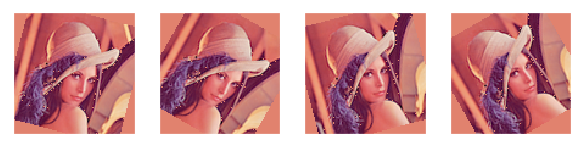

In [8]:
def rotate_img(img, angle, bg_patch=(5,5)):
    assert len(img.shape) <= 3, "Incorrect image shape"
    rgb = len(img.shape) == 3
    if rgb:
        bg_color = np.mean(img[:bg_patch[0], :bg_patch[1], :], axis=(0,1))
    else:
        bg_color = np.mean(img[:bg_patch[0], :bg_patch[1]])
    img = rotate(img, angle, reshape=False)
    mask = [img <= 0, np.any(img <= 0, axis=-1)][rgb]
    img[mask] = bg_color
    return img

plot_grid([rotate_img(img, angle=-15),
           rotate_img(img, angle=-30), 
           rotate_img(img, angle=15),
           rotate_img(img, angle=30),],
           1, 4, figsize=(10, 5))

### Random Noise

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


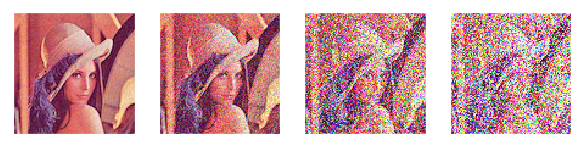

In [9]:
def gaussian_noise(img, mean=0, sigma=0.03):
    img = img.copy()
    noise = np.random.normal(mean, sigma, img.shape)
    mask_overflow_upper = img+noise >= 1.0
    mask_overflow_lower = img+noise < 0
    noise[mask_overflow_upper] = 1.0
    noise[mask_overflow_lower] = 0
    img += noise
    return img


plot_grid([gaussian_noise(img, sigma=0.03),
           gaussian_noise(img, sigma=0.1), 
           gaussian_noise(img, sigma=0.3),
           gaussian_noise(img, sigma=0.5)],
           1, 4, figsize=(10, 5))

### Distortions

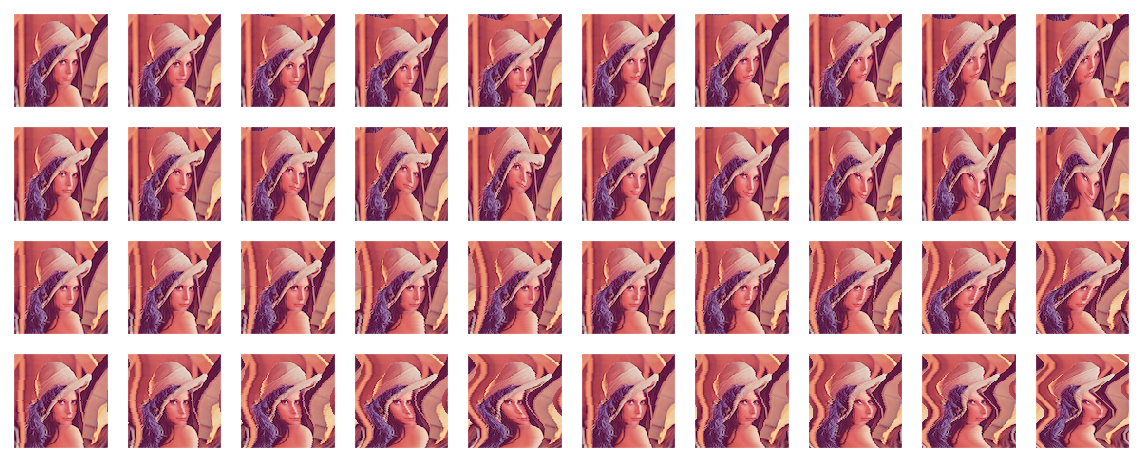

In [10]:
def distort(img, orientation='horizontal', func=np.sin, x_scale=0.05, y_scale=5):
    assert orientation[:3] in ['hor', 'ver'], "dist_orient should be 'horizontal'|'vertical'"
    assert func in [np.sin, np.cos], "supported functions are np.sin and np.cos"
    assert 0.00 <= x_scale <= 0.1, "x_scale should be in [0.0, 0.1]"
    assert 0 <= y_scale <= min(img.shape[0], img.shape[1]), "y_scale should be less then image size"
    img_dist = img.copy()
    
    def shift(x):
        return int(y_scale * func(np.pi * x * x_scale))
    
    for c in range(3):
        for i in range(img.shape[orientation.startswith('ver')]):
            if orientation.startswith('ver'):
                img_dist[:, i, c] = np.roll(img[:, i, c], shift(i))
            else:
                img_dist[i, :, c] = np.roll(img[i, :, c], shift(i))
            
    return img_dist

imgs_distorted = []
for ori in ['ver', 'hor']:
    for x_param in [0.01, 0.02, 0.03, 0.04]:
        for y_param in [2, 4, 6, 8, 10]:
            imgs_distorted.append(distort(img, orientation=ori, x_scale=x_param, y_scale=y_param))

plot_grid(imgs_distorted, 4, 10, figsize=(20, 8))

### Color channels change

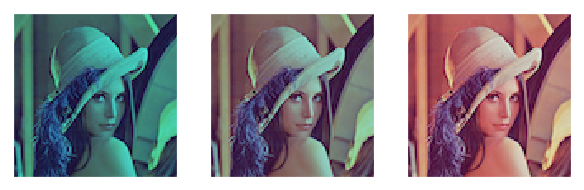

In [11]:
def change_channel_ratio(img, channel='r', ratio=0.5):
    assert channel in 'rgb', "Value for channel: r|g|b"
    img = img.copy()
    ci = 'rgb'.index(channel)
    img[:, :, ci] *= ratio
    return img

plot_grid([change_channel_ratio(img, ratio=0.3),
           change_channel_ratio(img, ratio=0.6), 
           change_channel_ratio(img, ratio=0.9)],
           1, 3, figsize=(10, 5))

In [12]:
def change_channel_ratio_gauss(img, channel='r', mean=0, sigma=0.03):
    assert channel in 'rgb', "cahenel must be r|g|b"
    img = img.copy()
    ci = 'rgb'.index(channel)
    img[:, :, ci] = gaussian_noise(img[:, :, ci], mean=mean, sigma=sigma)
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


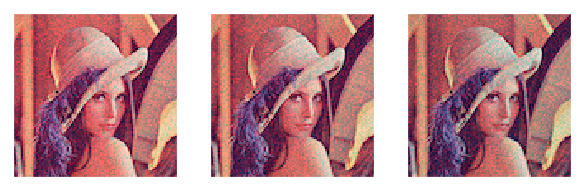

In [13]:
plot_grid([change_channel_ratio_gauss(img, mean=-0.01, sigma=0.1),
           change_channel_ratio_gauss(img, mean=-0.05, sigma=0.1), 
           change_channel_ratio_gauss(img, mean=-0.1, sigma=0.1)],
           1, 3, figsize=(10, 5))